In [1]:
#ライブラリをインポート
import os #OSに依存する様々な機能を利用するためのモジュール(ファイルやディレクトリ操作など)
import re #正規表現を利用するためのモジュール
import csv  #csvファイルを扱うためのモジュール
import math #数学的計算のためのモジュール
from decimal import Decimal #小数点桁落ちをなくすためのモジュール
import matplotlib.pyplot as plt #グラフ描画のためのモジュール
import numpy as np  #多次元配列計算のためのモジュール
import pandas as pd #データフレームを扱うためのモジュール
from scipy import signal  #信号処理のためのモジュール
from scipy.stats import skew, kurtosis  #歪度と尖度を調べるためのモジュール
from sklearn.model_selection import train_test_split  #データをトレーニング用とテスト用に分けるためのモジュール
from sklearn import preprocessing #データを正規化するためのモジュール
from sklearn.preprocessing import StandardScaler  #データを標準化するためのモジュール
from sklearn.preprocessing import LabelEncoder  #カテゴリ変数を数値化するためのモジュール
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score #機械学習モデルの性能評価のためのモジュール
import tensorflow as tf #TensorFlow(Googleが開発したオープンソースの機械学習フレームワーク)
from tensorflow import keras  #TensorFlow用のニューラルネットワークライブラリAPI
from tensorflow.keras import layers #ニューラルネットワークのレイヤーを定義するためのモジュール

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#定数を定義
BINS = 100  #ヒストグラムのビンの数
EPSILON = .00001  #スムージングパラメータ
UPPER_LIMIT = 1.1 #静止区間の上限
LOWER_LIMIT = 0.9 #静止区間の加減
STATIONARY_INTERVALS = 5  #静止区間除去のサンプルの間隔(静止区間が何サンプル連続したら除去するか)
TRAIN_SIZE = 0.8  #機械学習のトレーニングデータの割合

In [5]:
#ファイル名と周波数を分けて出力する関数
def divide_Hz_and_filename(Hz_and_filename: list[int, str]) -> tuple[list[int], list[str]]:
    Hz = []
    filename = []
    for row in Hz_and_filename:
      Hz.append(row[0])
      filename.append(row[1])
    return Hz, filename

In [6]:
#Hascの加速度データのCSVファイルから3軸加速度を取得する関数
def get_acceleration(filename: str) -> tuple[list[float], list[float], list[float]]:
    AccX, AccY, AccZ = [], [], []
    with open(filename) as f:
        reader = csv.reader(f)
        for row in reader:
            AccX.append(float(row[1]))
            AccY.append(float(row[2]))
            AccZ.append(float(row[3]))

    return AccX, AccY, AccZ

In [7]:
#静止区間を除去する関数
def acc_to_remove_stationary_intervals(AccX: list[float], AccY: list[float], AccZ: list[float]) -> list[float]:
    #各軸の加速度の平均を求める
    AvgAccX = sum(AccX) / len(AccX)
    AvgAccY = sum(AccY) / len(AccY)
    AvgAccZ = sum(AccZ) / len(AccZ)

    AvgResultantAcc = math.sqrt(AvgAccX ** 2 + AvgAccY ** 2 + AvgAccZ ** 2) #重力加速度の推定値=合成加速度の平均を求める

    ResultantAcc = [math.sqrt(x ** 2 + y ** 2 + z ** 2) for x, y, z in zip(AccX, AccY, AccZ)]   #各時刻の合成加速度を求める

    #各時刻の合成加速度から静止区間(重力加速度の推定値に近い値が一定以上以上連続している区間)を除去する
    i = 0 #ループ変数
    counter = 0 #静止区間がSTATIONARY_INTERVALS分続いているかをカウントする変数
    while i < len(ResultantAcc):
        if AvgResultantAcc * LOWER_LIMIT < ResultantAcc[i] < AvgResultantAcc * UPPER_LIMIT:   #平均のLOWER_LIMIT倍~UPPER_LIMIT倍の範囲を調べる
            counter += 1    #範囲内ならカウントを増やす
            if counter == STATIONARY_INTERVALS: #カウントがSTATIONARY_INTERVALSに達したらその区間を削除
                del ResultantAcc[i+1-STATIONARY_INTERVALS:i+1]    #スライスでは選択範囲の開始位置startと終了位置stopを[start:stop]のように書くとstart <= x < stopの範囲が選択される #start番目の値は含まれるがstop番目の値は含まれない
                counter = 0 #カウンターをリセット
                i -= STATIONARY_INTERVALS   #削除した分インデックスがズレるので補正する
        else:
            counter = 0 #カウンターをリセット
        i += 1

    return ResultantAcc  #静止区間を除去した後のリストを返す

In [8]:
#連続する2サンプルの差分を取る関数
def calculate_differences_of_acceleration(ResultantAcc: list[float]) -> list[float]:
    DifferenceAcc = [math.fabs(Decimal(ResultantAcc[i + 1]) - Decimal(ResultantAcc[i])) for i in range(len(ResultantAcc) - 1)]  #連続する2サンプルの誤差を取る
    return DifferenceAcc

In [9]:
#入力された加速度の差分のリストからヒストグラムを作る関数（ビンの範囲が各加速度の差分データの最小値〜最大値）
def create_histogram2(DifferenceAcc_list: list[float]) -> np.histogram:
    DifferenceAcc_hist = np.zeros((len(DifferenceAcc_list), BINS), dtype=float)
    for i in range(len(DifferenceAcc_list)):
        min_value = min(DifferenceAcc_list[i])
        max_value = max(DifferenceAcc_list[i])
        #DifferenceAcc_hist[i], _ = np.histogram(DifferenceAcc_list[i], bins=BINS, range=(min_value, max_value)) #ヒストグラムを作成し、同じ数のビンで区切る
        DifferenceAcc_hist[i], _ = np.histogram(DifferenceAcc_list[i], bins=BINS, density=True) #ヒストグラムを作成し、同じ数のビンで区切る
    return DifferenceAcc_hist

In [10]:
#各加速度データをダウンサンプリングする関数
def resampling_Acc(originHz: int, newHz: int, AccX: list[float], AccY: list[float], AccZ: list[float], Hz: np.array) -> tuple[list[float], list[float], list[float], np.array]:
    i = 0   #カウンター変数

    while (Hz[i] == originHz):
        originlen = len(AccX[i])    #元々のデータの長さ
        sampling_factor = int(originlen * (newHz/originHz)) #ダウンサンプリングした後のデータの長さ
        newAccX = signal.resample(AccX[i], sampling_factor)    #データをダウンサンプリング
        newAccY = signal.resample(AccY[i], sampling_factor)    #データをダウンサンプリング
        newAccZ = signal.resample(AccZ[i], sampling_factor)    #データをダウンサンプリング
        AccX.append(newAccX)   #ダウンサンプリングデータを加速度データに追加
        AccY.append(newAccY)   #ダウンサンプリングデータを加速度データに追加
        AccZ.append(newAccZ)   #ダウンサンプリングデータを加速度データに追加
        Hz = np.append(Hz, newHz)   #ダウンサンプリングレートを追加
        i += 1

    return AccX, AccY, AccZ, Hz

In [11]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [12]:
#path名から標準化されたヒストグラムと正解ラベルを返す関数
def path_to_histogram(path: str) -> tuple[np.array, np.array]:
    filename = os.listdir(path) #引数のパスのディレクトリの中のファイル名一覧を取得
    #使う変数を宣言
    readAccX, readAccY, readAccZ = [], [], []   #データ読み込む用
    AccX, AccY, AccZ = [], [], []
    ResultantAcc = []
    DifferenceAcc_list = []

    #各データセットからデータを読み込み二次元配列に格納
    for i in filename:
        readAccX, readAccY, readAccZ = get_acceleration(path+i)
        AccX.append(readAccX), AccY.append(readAccY), AccZ.append(readAccZ)

    Hz = np.ones(len(filename)) * 100

    #各加速度データをダウンサンプリング
    for i in range(9, 1, -1):
        AccX, AccY, AccZ, Hz = resampling_Acc(100, i * 10, AccX, AccY, AccZ, Hz)

    #静止区間を除去
    for i in range(len(Hz)):
        ResultantAcc.append(acc_to_remove_stationary_intervals(AccX[i], AccY[i], AccZ[i]))

    #ヒストグラム作成
    for i in range(len(ResultantAcc)):
        DifferenceAcc_list.append(calculate_differences_of_acceleration(ResultantAcc[i]))
    DifferenceAcc_hist = create_histogram2(DifferenceAcc_list)

    #標準化
    scaler = StandardScaler()
    # Fit the scaler to x_train
    scaler.fit(DifferenceAcc_hist)
    # Use the scaler to transform x_train and x_test
    DifferenceAcc_hist = scaler.transform(DifferenceAcc_hist)

    return DifferenceAcc_hist, Hz

In [ ]:
pathHasc = "/content/drive/MyDrive/hasc(walk)/"
filename = os.listdir(pathHasc) #引数のパスのディレクトリの中のファイル名一覧を取得
#filename.remove(".DS_Store")

In [ ]:
#使う変数を宣言
readAccX, readAccY, readAccZ = [], [], []   #データ読み込む用
AccX, AccY, AccZ = [], [], []
ResultantAcc = []
DifferenceAcc_list = []

#各データセットからデータを読み込み二次元配列に格納
for i in filename:
    readAccX, readAccY, readAccZ = get_acceleration(pathHasc+i)
    AccX.append(readAccX), AccY.append(readAccY), AccZ.append(readAccZ)

HzHasc = np.ones(len(filename)) * 100

#各加速度データをダウンサンプリング
for i in range(9, 1, -1):
    AccX, AccY, AccZ, HzHasc = resampling_Acc(100, i * 10, AccX, AccY, AccZ, HzHasc)

#静止区間を除去
for i in range(len(HzHasc)):
    ResultantAcc.append(acc_to_remove_stationary_intervals(AccX[i], AccY[i], AccZ[i]))

In [ ]:
#ヒストグラム作成
for i in range(len(ResultantAcc)):
    DifferenceAcc_list.append(calculate_differences_of_acceleration(ResultantAcc[i]))
DifferenceAcc_histHasc = create_histogram2(DifferenceAcc_list)

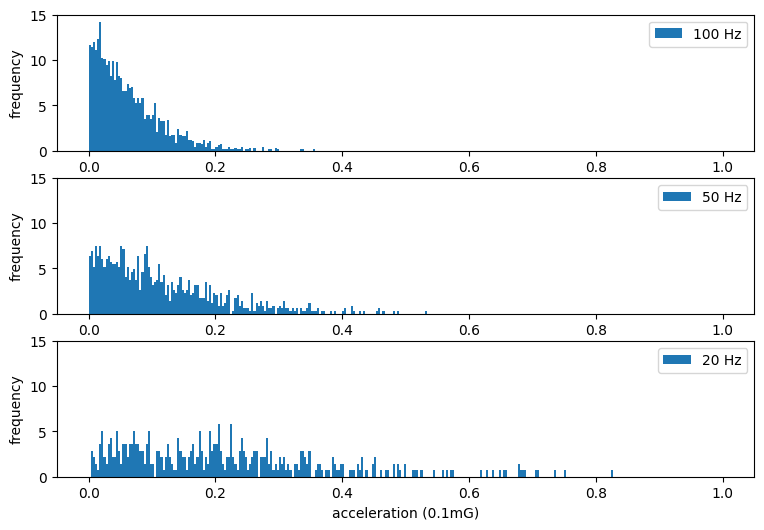

In [ ]:
#グラフを表示する領域を，figオブジェクトとして作成。
fig = plt.figure(figsize = (9,6))
xl1 = "acceleration (0.1mG)"
yl1 = "frequency"

#グラフを描画するsubplot領域を作成。
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

#各subplot領域にデータを渡す(範囲指定)
ax1.hist(DifferenceAcc_list[0], bins=BINS,density=True, range=(0, 1), label="100 Hz")
ax2.hist(DifferenceAcc_list[260], bins=BINS,density=True, range=(0, 1), label="50 Hz")
ax3.hist(DifferenceAcc_list[416], bins=BINS,density=True, range=(0, 1), label="20 Hz")

#各subplot領域にデータを渡す
#ax1.hist(DifferenceAcc_list[0], bins=BINS,density=True, label="100 Hz")
#ax2.hist(DifferenceAcc_list[260], bins=BINS,density=True, label="50 Hz")
#ax3.hist(DifferenceAcc_list[416], bins=BINS,density=True, label="20 Hz")

#各subplotにxラベルを追加
ax1.set_xlabel(xl1)
ax2.set_xlabel(xl1)
ax3.set_xlabel(xl1)

#各subplotにyラベルを追加
ax1.set_ylabel(yl1)
ax2.set_ylabel(yl1)
ax3.set_ylabel(yl1)

#各subplotのy軸の範囲を指定
ax1.set_ylim(0, 15)
ax2.set_ylim(0, 15)
ax3.set_ylim(0, 15)

# 凡例表示
ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper right')
ax3.legend(loc = 'upper right')

plt.show()

In [ ]:
skew(DifferenceAcc_histHasc[416])

1.4953005999452054

In [ ]:
pathHascJog = "/content/drive/MyDrive/hasc(jog)/"
filename = os.listdir(pathHascJog) #引数のパスのディレクトリの中のファイル名一覧を取得
#filename.remove(".DS_Store")

In [ ]:
#使う変数を宣言
readAccX, readAccY, readAccZ = [], [], []   #データ読み込む用
AccX, AccY, AccZ = [], [], []
ResultantAcc = []
DifferenceAcc_list = []

#各データセットからデータを読み込み二次元配列に格納
for i in filename:
    readAccX, readAccY, readAccZ = get_accelerationHasc(pathHascJog+i)
    AccX.append(readAccX), AccY.append(readAccY), AccZ.append(readAccZ)

HzHascJog = np.ones(len(filename)) * 100

#各加速度データをダウンサンプリング
for i in range(9, 1, -1):
    AccX, AccY, AccZ, HzHascJog = resampling_Acc(100, i * 10, AccX, AccY, AccZ, HzHascJog)

#静止区間を除去
for i in range(len(HzHascJog)):
    ResultantAcc.append(acc_to_remove_stationary_intervals(AccX[i], AccY[i], AccZ[i]))

In [ ]:
#ヒストグラム作成
for i in range(len(ResultantAcc)):
    DifferenceAcc_list.append(calculate_differences_of_acceleration(ResultantAcc[i]))
DifferenceAcc_histHascJog = create_histogram2(DifferenceAcc_list)

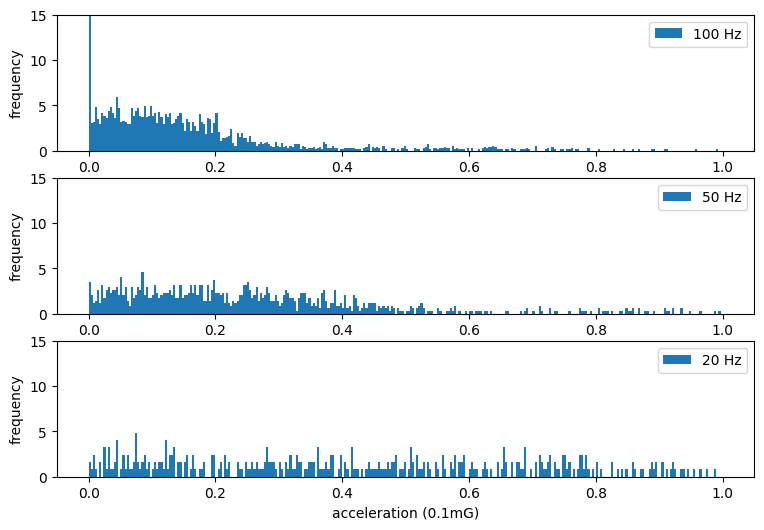

In [ ]:
#グラフを表示する領域を，figオブジェクトとして作成。
fig = plt.figure(figsize = (9,6))
xl1 = "acceleration (0.1mG)"
yl1 = "frequency"

#グラフを描画するsubplot領域を作成。
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

#各subplot領域にデータを渡す(範囲指定)
ax1.hist(DifferenceAcc_list[0], bins=BINS,density=True, range=(0, 1), label="100 Hz")
ax2.hist(DifferenceAcc_list[260], bins=BINS,density=True, range=(0, 1), label="50 Hz")
ax3.hist(DifferenceAcc_list[416], bins=BINS,density=True, range=(0, 1), label="20 Hz")

#各subplot領域にデータを渡す
#ax1.hist(DifferenceAcc_list[0], bins=BINS,density=True, label="100 Hz")
#ax2.hist(DifferenceAcc_list[260], bins=BINS,density=True, label="50 Hz")
#ax3.hist(DifferenceAcc_list[416], bins=BINS,density=True, label="20 Hz")

#各subplotにxラベルを追加
ax1.set_xlabel(xl1)
ax2.set_xlabel(xl1)
ax3.set_xlabel(xl1)

#各subplotにyラベルを追加
ax1.set_ylabel(yl1)
ax2.set_ylabel(yl1)
ax3.set_ylabel(yl1)

#各subplotのy軸の範囲を指定
ax1.set_ylim(0, 15)
ax2.set_ylim(0, 15)
ax3.set_ylim(0, 15)

# 凡例表示
ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper right')
ax3.legend(loc = 'upper right')

plt.show()

In [ ]:
#標準化
scaler = StandardScaler()
# Fit the scaler to x_train
scaler.fit(DifferenceAcc_histHasc)
# Use the scaler to transform x_train and x_test
DifferenceAcc_histHasc = scaler.transform(DifferenceAcc_histHasc)

In [ ]:
#標準化
scaler = StandardScaler()
# Fit the scaler to x_train
scaler.fit(DifferenceAcc_histHascJog)
# Use the scaler to transform x_train and x_test
DifferenceAcc_histHascJog = scaler.transform(DifferenceAcc_histHascJog)

In [13]:
HistHascWalk, HzHascWalk = path_to_histogram("/content/drive/MyDrive/hasc(walk)/")

In [17]:
HistHascJog, HzHascJog = path_to_histogram("/content/drive/MyDrive/hasc(jog)/")

In [21]:
HistHascSkip, HzHascSkip = path_to_histogram("/content/drive/MyDrive/hasc(skip)/")

In [20]:
HistHascSequence, HzHascSequence = path_to_histogram("/content/drive/MyDrive/hasc(sequence)/")

In [22]:
#transformer regression
#各種パラメータ
NUM_HEADS = 2
KEY_DIM = 50
BINS = 100
DROPOUT = 0.1
N = 1

# Define the input shape
input_shape = (BINS,)
output_shape = (1,)

#形を定義(このモジュールは行列でないとダメっぽい)
inputs_encoder = layers.Input(shape=input_shape)
inputs_decoder = layers.Input(shape=output_shape)

In [23]:
#Encoderに対する入力の形状
x_encoder = layers.Reshape((1, 100))(inputs_encoder)

In [24]:
#Transformer Encoder Layer(BERT)
for i in range(N):
      #Multi-Head-Attention Layer
      attention_encoder = layers.MultiHeadAttention(num_heads=NUM_HEADS, key_dim=KEY_DIM, use_bias=True)(x_encoder, x_encoder, x_encoder)

      #Dropout Layer
      attention_encoder = layers.Dropout(rate=DROPOUT)(attention_encoder)
      #Add & Norm Layer
      attention_encoder = layers.LayerNormalization()(x_encoder + attention_encoder)

      #Feed-Forward-Network
      ffn_encoder = layers.Dense(BINS * 4, use_bias=True, activation="relu")(attention_encoder)
      ffn_encoder = layers.Dense(BINS, use_bias=True)(ffn_encoder)

      #Dropout Layer
      ffn_encoder = layers.Dropout(rate=DROPOUT)(ffn_encoder)
      #Add & Norm Layer
      x_encoder = layers.LayerNormalization()(attention_encoder + ffn_encoder)

In [25]:
x = layers.Flatten()(x_encoder)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(16, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="relu")(x)

In [26]:
model = keras.Model(inputs=inputs_encoder, outputs=outputs)

In [27]:
# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.mean_squared_error,
    metrics=[keras.metrics.mean_squared_error],
)

In [28]:
mae = []
mse = []
r2 = []

In [29]:
EPOCHS = 100

In [30]:
#HascWalkで構築→HascJogで試す
history = model.fit(HistHascWalk, HzHascWalk, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascJog), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascJog))
mse.append(mean_squared_error(y_pred, HzHascJog))
r2.append(r2_score(y_pred, HzHascJog))

Epoch 1/100
12/12 [==============================] - 10s 37ms/step - loss: 4920.2388 - mean_squared_error: 4920.2388 - val_loss: 468.9461 - val_mean_squared_error: 468.9461
Epoch 2/100
12/12 [==============================] - 0s 12ms/step - loss: 4420.6807 - mean_squared_error: 4420.6807 - val_loss: 304.8834 - val_mean_squared_error: 304.8834
Epoch 3/100
12/12 [==============================] - 0s 10ms/step - loss: 3840.6284 - mean_squared_error: 3840.6284 - val_loss: 138.8433 - val_mean_squared_error: 138.8433
Epoch 4/100
12/12 [==============================] - 0s 10ms/step - loss: 3118.9478 - mean_squared_error: 3118.9478 - val_loss: 25.8211 - val_mean_squared_error: 25.8211
Epoch 5/100
12/12 [==============================] - 0s 10ms/step - loss: 2231.0432 - mean_squared_error: 2231.0432 - val_loss: 140.0466 - val_mean_squared_error: 140.0466
Epoch 6/100
12/12 [==============================] - 0s 10ms/step - loss: 1319.3722 - mean_squared_error: 1319.3722 - val_loss: 688.3649 - va

In [31]:
#HascWalkで構築→HascSkipで試す
history = model.fit(HistHascWalk, HzHascWalk, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascSkip), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascSkip))
mse.append(mean_squared_error(y_pred, HzHascSkip))
r2.append(r2_score(y_pred, HzHascSkip))

Epoch 1/100
12/12 [==============================] - 0s 13ms/step - loss: 136.4393 - mean_squared_error: 136.4393 - val_loss: 563.4056 - val_mean_squared_error: 563.4056
Epoch 2/100
12/12 [==============================] - 0s 11ms/step - loss: 119.2811 - mean_squared_error: 119.2811 - val_loss: 589.8683 - val_mean_squared_error: 589.8683
Epoch 3/100
12/12 [==============================] - 0s 10ms/step - loss: 136.2973 - mean_squared_error: 136.2973 - val_loss: 597.9196 - val_mean_squared_error: 597.9196
Epoch 4/100
12/12 [==============================] - 0s 10ms/step - loss: 121.5720 - mean_squared_error: 121.5720 - val_loss: 579.6498 - val_mean_squared_error: 579.6498
Epoch 5/100
12/12 [==============================] - 0s 12ms/step - loss: 123.6796 - mean_squared_error: 123.6796 - val_loss: 474.2768 - val_mean_squared_error: 474.2768
Epoch 6/100
12/12 [==============================] - 0s 12ms/step - loss: 131.8988 - mean_squared_error: 131.8988 - val_loss: 659.6595 - val_mean_squa

In [32]:
#HascWalkで構築→HascSequenceで試す
history = model.fit(HistHascWalk, HzHascWalk, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascSequence), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascSequence))
mse.append(mean_squared_error(y_pred, HzHascSequence))
r2.append(r2_score(y_pred, HzHascSequence))

Epoch 1/100
12/12 [==============================] - 0s 15ms/step - loss: 110.2948 - mean_squared_error: 110.2948 - val_loss: 519.3941 - val_mean_squared_error: 519.3941
Epoch 2/100
12/12 [==============================] - 0s 11ms/step - loss: 116.7817 - mean_squared_error: 116.7817 - val_loss: 527.1140 - val_mean_squared_error: 527.1140
Epoch 3/100
12/12 [==============================] - 0s 9ms/step - loss: 123.0473 - mean_squared_error: 123.0473 - val_loss: 596.6904 - val_mean_squared_error: 596.6904
Epoch 4/100
12/12 [==============================] - 0s 10ms/step - loss: 114.2259 - mean_squared_error: 114.2259 - val_loss: 628.2011 - val_mean_squared_error: 628.2011
Epoch 5/100
12/12 [==============================] - 0s 10ms/step - loss: 115.5521 - mean_squared_error: 115.5521 - val_loss: 618.2022 - val_mean_squared_error: 618.2022
Epoch 6/100
12/12 [==============================] - 0s 10ms/step - loss: 115.8302 - mean_squared_error: 115.8302 - val_loss: 518.4475 - val_mean_squar

In [34]:
#HascJogで構築→HascWalkで試す
history = model.fit(HistHascJog, HzHascJog, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascWalk), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascWalk))
mse.append(mean_squared_error(y_pred, HzHascWalk))
r2.append(r2_score(y_pred, HzHascWalk))

Epoch 1/100
12/12 [==============================] - 0s 18ms/step - loss: 422.9373 - mean_squared_error: 422.9373 - val_loss: 537.3199 - val_mean_squared_error: 537.3199
Epoch 2/100
12/12 [==============================] - 0s 16ms/step - loss: 325.0695 - mean_squared_error: 325.0695 - val_loss: 527.7675 - val_mean_squared_error: 527.7675
Epoch 3/100
12/12 [==============================] - 0s 16ms/step - loss: 289.8866 - mean_squared_error: 289.8866 - val_loss: 430.3819 - val_mean_squared_error: 430.3819
Epoch 4/100
12/12 [==============================] - 0s 17ms/step - loss: 239.4047 - mean_squared_error: 239.4047 - val_loss: 338.9077 - val_mean_squared_error: 338.9077
Epoch 5/100
12/12 [==============================] - 0s 10ms/step - loss: 255.1803 - mean_squared_error: 255.1803 - val_loss: 453.6302 - val_mean_squared_error: 453.6302
Epoch 6/100
12/12 [==============================] - 0s 10ms/step - loss: 230.7559 - mean_squared_error: 230.7559 - val_loss: 279.3824 - val_mean_squa

In [35]:
#HascJogで構築→HascSkipで試す
history = model.fit(HistHascJog, HzHascJog, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascSkip), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascSkip))
mse.append(mean_squared_error(y_pred, HzHascSkip))
r2.append(r2_score(y_pred, HzHascSkip))

Epoch 1/100
12/12 [==============================] - 0s 13ms/step - loss: 118.9645 - mean_squared_error: 118.9645 - val_loss: 471.4254 - val_mean_squared_error: 471.4254
Epoch 2/100
12/12 [==============================] - 0s 9ms/step - loss: 110.9159 - mean_squared_error: 110.9159 - val_loss: 404.2200 - val_mean_squared_error: 404.2200
Epoch 3/100
12/12 [==============================] - 0s 10ms/step - loss: 112.0675 - mean_squared_error: 112.0675 - val_loss: 412.1711 - val_mean_squared_error: 412.1711
Epoch 4/100
12/12 [==============================] - 0s 9ms/step - loss: 131.1759 - mean_squared_error: 131.1759 - val_loss: 410.3395 - val_mean_squared_error: 410.3395
Epoch 5/100
12/12 [==============================] - 0s 10ms/step - loss: 117.1957 - mean_squared_error: 117.1957 - val_loss: 420.1971 - val_mean_squared_error: 420.1971
Epoch 6/100
12/12 [==============================] - 0s 10ms/step - loss: 114.3168 - mean_squared_error: 114.3168 - val_loss: 477.0091 - val_mean_square

In [36]:
#HascJogで構築→HascSequenceで試す
history = model.fit(HistHascJog, HzHascJog, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascSequence), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascSequence))
mse.append(mean_squared_error(y_pred, HzHascSequence))
r2.append(r2_score(y_pred, HzHascSequence))

Epoch 1/100
12/12 [==============================] - 0s 12ms/step - loss: 114.9170 - mean_squared_error: 114.9170 - val_loss: 390.1343 - val_mean_squared_error: 390.1343
Epoch 2/100
12/12 [==============================] - 0s 9ms/step - loss: 110.4908 - mean_squared_error: 110.4908 - val_loss: 465.3356 - val_mean_squared_error: 465.3356
Epoch 3/100
12/12 [==============================] - 0s 10ms/step - loss: 102.3903 - mean_squared_error: 102.3903 - val_loss: 477.9060 - val_mean_squared_error: 477.9060
Epoch 4/100
12/12 [==============================] - 0s 10ms/step - loss: 116.0602 - mean_squared_error: 116.0602 - val_loss: 492.0605 - val_mean_squared_error: 492.0605
Epoch 5/100
12/12 [==============================] - 0s 11ms/step - loss: 104.4285 - mean_squared_error: 104.4285 - val_loss: 417.0812 - val_mean_squared_error: 417.0812
Epoch 6/100
12/12 [==============================] - 0s 10ms/step - loss: 141.1973 - mean_squared_error: 141.1973 - val_loss: 489.3922 - val_mean_squar

In [38]:
#HascSkipで構築→HascWalkで試す
history = model.fit(HistHascSkip, HzHascSkip, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascWalk), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascWalk))
mse.append(mean_squared_error(y_pred, HzHascWalk))
r2.append(r2_score(y_pred, HzHascWalk))

Epoch 1/100
13/13 [==============================] - 0s 20ms/step - loss: 446.0904 - mean_squared_error: 446.0904 - val_loss: 1233.7587 - val_mean_squared_error: 1233.7587
Epoch 2/100
13/13 [==============================] - 0s 18ms/step - loss: 366.4115 - mean_squared_error: 366.4115 - val_loss: 1122.7402 - val_mean_squared_error: 1122.7402
Epoch 3/100
13/13 [==============================] - 0s 14ms/step - loss: 356.3703 - mean_squared_error: 356.3703 - val_loss: 879.5129 - val_mean_squared_error: 879.5129
Epoch 4/100
13/13 [==============================] - 0s 15ms/step - loss: 341.9777 - mean_squared_error: 341.9777 - val_loss: 1387.6569 - val_mean_squared_error: 1387.6569
Epoch 5/100
13/13 [==============================] - 0s 18ms/step - loss: 338.3653 - mean_squared_error: 338.3653 - val_loss: 1167.0966 - val_mean_squared_error: 1167.0966
Epoch 6/100
13/13 [==============================] - 0s 15ms/step - loss: 321.8507 - mean_squared_error: 321.8507 - val_loss: 1124.7588 - val_

In [39]:
#HascSkipで構築→HascJogで試す
history = model.fit(HistHascSkip, HzHascSkip, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascJog), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascJog))
mse.append(mean_squared_error(y_pred, HzHascJog))
r2.append(r2_score(y_pred, HzHascJog))

Epoch 1/100
13/13 [==============================] - 0s 13ms/step - loss: 297.3950 - mean_squared_error: 297.3950 - val_loss: 1158.0642 - val_mean_squared_error: 1158.0642
Epoch 2/100
13/13 [==============================] - 0s 10ms/step - loss: 297.2344 - mean_squared_error: 297.2344 - val_loss: 1252.4465 - val_mean_squared_error: 1252.4465
Epoch 3/100
13/13 [==============================] - 0s 10ms/step - loss: 291.1385 - mean_squared_error: 291.1385 - val_loss: 1161.0034 - val_mean_squared_error: 1161.0034
Epoch 4/100
13/13 [==============================] - 0s 10ms/step - loss: 252.6643 - mean_squared_error: 252.6643 - val_loss: 1201.7405 - val_mean_squared_error: 1201.7405
Epoch 5/100
13/13 [==============================] - 0s 10ms/step - loss: 260.9529 - mean_squared_error: 260.9529 - val_loss: 1266.4883 - val_mean_squared_error: 1266.4883
Epoch 6/100
13/13 [==============================] - 0s 12ms/step - loss: 274.7759 - mean_squared_error: 274.7759 - val_loss: 1247.0809 - va

In [40]:
#HascSkipで構築→HascSequenceで試す
history = model.fit(HistHascSkip, HzHascSkip, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascSequence), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascSequence))
mse.append(mean_squared_error(y_pred, HzHascSequence))
r2.append(r2_score(y_pred, HzHascSequence))

Epoch 1/100
13/13 [==============================] - 0s 18ms/step - loss: 289.6553 - mean_squared_error: 289.6553 - val_loss: 1168.1119 - val_mean_squared_error: 1168.1119
Epoch 2/100
13/13 [==============================] - 0s 14ms/step - loss: 265.5629 - mean_squared_error: 265.5629 - val_loss: 1250.1260 - val_mean_squared_error: 1250.1260
Epoch 3/100
13/13 [==============================] - 0s 16ms/step - loss: 282.3963 - mean_squared_error: 282.3963 - val_loss: 1267.2621 - val_mean_squared_error: 1267.2621
Epoch 4/100
13/13 [==============================] - 0s 14ms/step - loss: 267.1438 - mean_squared_error: 267.1438 - val_loss: 1219.8601 - val_mean_squared_error: 1219.8601
Epoch 5/100
13/13 [==============================] - 0s 14ms/step - loss: 284.0536 - mean_squared_error: 284.0536 - val_loss: 1268.5748 - val_mean_squared_error: 1268.5748
Epoch 6/100
13/13 [==============================] - 0s 14ms/step - loss: 263.3330 - mean_squared_error: 263.3330 - val_loss: 1377.1357 - va

In [42]:
#HascSequenceで構築→HascWalkで試す
history = model.fit(HistHascSequence, HzHascSequence, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascWalk), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascWalk))
mse.append(mean_squared_error(y_pred, HzHascWalk))
r2.append(r2_score(y_pred, HzHascWalk))

Epoch 1/100
9/9 [==============================] - 0s 17ms/step - loss: 326.6687 - mean_squared_error: 326.6687 - val_loss: 795.8733 - val_mean_squared_error: 795.8733
Epoch 2/100
9/9 [==============================] - 0s 11ms/step - loss: 296.6583 - mean_squared_error: 296.6583 - val_loss: 677.5688 - val_mean_squared_error: 677.5688
Epoch 3/100
9/9 [==============================] - 0s 10ms/step - loss: 275.9975 - mean_squared_error: 275.9975 - val_loss: 606.9045 - val_mean_squared_error: 606.9045
Epoch 4/100
9/9 [==============================] - 0s 12ms/step - loss: 251.5492 - mean_squared_error: 251.5492 - val_loss: 586.9288 - val_mean_squared_error: 586.9288
Epoch 5/100
9/9 [==============================] - 0s 12ms/step - loss: 215.9714 - mean_squared_error: 215.9714 - val_loss: 714.5413 - val_mean_squared_error: 714.5413
Epoch 6/100
9/9 [==============================] - 0s 12ms/step - loss: 228.0227 - mean_squared_error: 228.0227 - val_loss: 693.5040 - val_mean_squared_error: 6

In [43]:
#HascSequenceで構築→HascJogで試す
history = model.fit(HistHascSequence, HzHascSequence, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascJog), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascJog))
mse.append(mean_squared_error(y_pred, HzHascJog))
r2.append(r2_score(y_pred, HzHascJog))

Epoch 1/100
9/9 [==============================] - 0s 22ms/step - loss: 127.5805 - mean_squared_error: 127.5805 - val_loss: 692.6494 - val_mean_squared_error: 692.6494
Epoch 2/100
9/9 [==============================] - 0s 18ms/step - loss: 124.0856 - mean_squared_error: 124.0856 - val_loss: 641.6725 - val_mean_squared_error: 641.6725
Epoch 3/100
9/9 [==============================] - 0s 17ms/step - loss: 157.6208 - mean_squared_error: 157.6208 - val_loss: 774.7288 - val_mean_squared_error: 774.7288
Epoch 4/100
9/9 [==============================] - 0s 17ms/step - loss: 136.4485 - mean_squared_error: 136.4485 - val_loss: 685.9977 - val_mean_squared_error: 685.9977
Epoch 5/100
9/9 [==============================] - 0s 17ms/step - loss: 158.2985 - mean_squared_error: 158.2985 - val_loss: 741.0815 - val_mean_squared_error: 741.0815
Epoch 6/100
9/9 [==============================] - 0s 36ms/step - loss: 130.3861 - mean_squared_error: 130.3861 - val_loss: 723.2496 - val_mean_squared_error: 7

In [44]:
#HascSequenceで構築→HascSkipで試す
history = model.fit(HistHascSequence, HzHascSequence, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascSkip), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascSkip))
mse.append(mean_squared_error(y_pred, HzHascSkip))
r2.append(r2_score(y_pred, HzHascSkip))

Epoch 1/100
9/9 [==============================] - 0s 24ms/step - loss: 158.8583 - mean_squared_error: 158.8583 - val_loss: 693.3867 - val_mean_squared_error: 693.3867
Epoch 2/100
9/9 [==============================] - 0s 19ms/step - loss: 140.3947 - mean_squared_error: 140.3947 - val_loss: 768.2786 - val_mean_squared_error: 768.2786
Epoch 3/100
9/9 [==============================] - 0s 18ms/step - loss: 162.3538 - mean_squared_error: 162.3538 - val_loss: 717.9814 - val_mean_squared_error: 717.9814
Epoch 4/100
9/9 [==============================] - 0s 19ms/step - loss: 143.4376 - mean_squared_error: 143.4376 - val_loss: 731.1702 - val_mean_squared_error: 731.1702
Epoch 5/100
9/9 [==============================] - 0s 22ms/step - loss: 144.8559 - mean_squared_error: 144.8559 - val_loss: 729.5885 - val_mean_squared_error: 729.5885
Epoch 6/100
9/9 [==============================] - 0s 13ms/step - loss: 131.0866 - mean_squared_error: 131.0866 - val_loss: 658.1476 - val_mean_squared_error: 6

In [45]:
mae

[15.955128205128204,
 22.094949494949496,
 18.508333333333333,
 12.621794871794872,
 20.387878787878787,
 16.91111111111111,
 17.803418803418804,
 17.305555555555557,
 15.383333333333333,
 14.865384615384615,
 14.645299145299145,
 16.355555555555554]